In [ ]:
import pandas as pd

# Dataset Loading
Dataset used: https://www.kaggle.com/datasets/kartik2112/fraud-detection?select=fraudTrain.csv

In [4]:
df = pd.read_csv("fraudTrain.csv")
df.head()

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,...,36.0788,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0
1,1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,...,48.8878,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0
2,2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,...,42.1808,-112.2620,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0
3,3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,...,46.2306,-112.1138,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0
4,4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,...,38.4207,-79.4629,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0


In [28]:
df.shape

(1296675, 23)

In [5]:
df = df.drop(['Unnamed: 0','trans_num','merch_lat',"merch_long"], axis=1)

In [38]:
df.columns

Index(['trans_date_trans_time', 'cc_num', 'merchant', 'category', 'amt',
       'first', 'last', 'gender', 'street', 'city', 'state', 'zip', 'lat',
       'long', 'city_pop', 'job', 'dob', 'unix_time', 'merch_lat',
       'merch_long', 'is_fraud'],
      dtype='object')

In [6]:
df["is_fraud"].value_counts()

is_fraud
0    1289169
1       7506
Name: count, dtype: int64

As we can see that the data is heavily imbalanced so downscale to balance it.

# Data Preprocessing

In [7]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
import joblib
from datetime import datetime



# Convert 'trans_date_trans_time' to datetime and extract features
df['trans_date_trans_time'] = pd.to_datetime(df['trans_date_trans_time'])
df['year'] = df['trans_date_trans_time'].dt.year
df['month'] = df['trans_date_trans_time'].dt.month
df['day'] = df['trans_date_trans_time'].dt.day
df['hour'] = df['trans_date_trans_time'].dt.hour
df['weekday'] = df['trans_date_trans_time'].dt.weekday

# Convert 'dob' to datetime and calculate age
df['dob'] = pd.to_datetime(df['dob'])
current_year = datetime.now().year
df['age'] = current_year - df['dob'].dt.year

# Drop the original datetime columns as they're now redundant
df.drop(['trans_date_trans_time', 'dob'], axis=1, inplace=True)

# Handling categorical data
categorical_columns = ['merchant', 'category', 'first', 'last', 'gender', 'street', 'city', 'state', 'job']
encoders = {}
for col in categorical_columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    encoders[col] = le
    joblib.dump(le, f'encoders/{col}_encoder.pkl')  # Save each encoder to disk

# Balancing the data
df_majority = df[df['is_fraud'] == 0]
df_minority = df[df['is_fraud'] == 1]
df_majority_downsampled = df_majority.sample(n=len(df_minority), random_state=42)
df_balanced = pd.concat([df_minority, df_majority_downsampled]).sample(frac=1, random_state=42)

# Splitting the dataset into training and testing sets
X = df_balanced.drop('is_fraud', axis=1)
y = df_balanced['is_fraud']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [8]:
X_train.columns

Index(['cc_num', 'merchant', 'category', 'amt', 'first', 'last', 'gender',
       'street', 'city', 'state', 'zip', 'lat', 'long', 'city_pop', 'job',
       'unix_time', 'year', 'month', 'day', 'hour', 'weekday', 'age'],
      dtype='object')

In [ ]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score
import joblib

# Initialize models
models = {
    'RandomForest': RandomForestClassifier(random_state=42),
    'GradientBoosting': GradientBoostingClassifier(random_state=42),
    'LogisticRegression': LogisticRegression(max_iter=1000, random_state=42)
}

# Train and evaluate each model
results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    proba_predictions = model.predict_proba(X_test)[:, 1]  # Probability estimates for ROC AUC
    results[name] = {
        'Accuracy': accuracy_score(y_test, predictions),
        'ROC AUC': roc_auc_score(y_test, proba_predictions),
        'Classification Report': classification_report(y_test, predictions)
    }

# Print the evaluation results
for model_name, metrics in results.items():
    print(f"Results for {model_name}:")
    print(f"Accuracy: {metrics['Accuracy']}")
    print(f"ROC AUC: {metrics['ROC AUC']}")
    print("Classification Report:")
    print(metrics['Classification Report'])
    print("\n")

### As we can see from results, Random Forest out performs all other models, so lets move forward with that.

In [8]:
# Training the model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [9]:
# Evaluating the model
predictions = model.predict(X_test)
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.96      0.97      0.97      1508
           1       0.97      0.96      0.97      1495

    accuracy                           0.97      3003
   macro avg       0.97      0.97      0.97      3003
weighted avg       0.97      0.97      0.97      3003



In [10]:
# Saving the model
joblib.dump(model, 'fraud_detection_model.pkl')

['fraud_detection_model.pkl']

# Evaluation and Visualizations

In [12]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns 

## Classification Report

In [13]:
predictions = model.predict(X_test)
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.96      0.97      0.97      1508
           1       0.97      0.96      0.97      1495

    accuracy                           0.97      3003
   macro avg       0.97      0.97      0.97      3003
weighted avg       0.97      0.97      0.97      3003



## Confusion Matrix

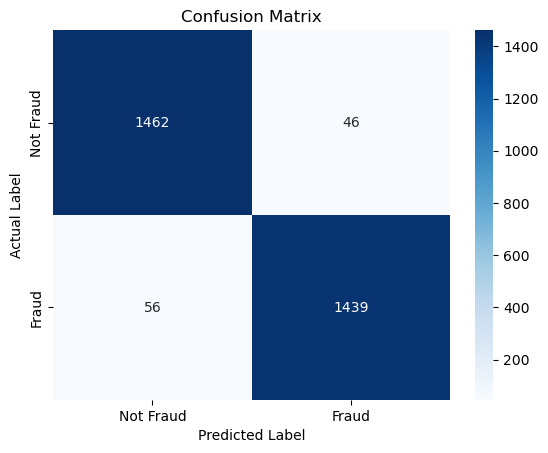

In [14]:
conf_matrix = confusion_matrix(y_test, predictions)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Fraud', 'Fraud'], yticklabels=['Not Fraud', 'Fraud'])
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')
plt.show()

## Accuracy Score

In [15]:
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: {:.2f}%".format(accuracy * 100))

Accuracy: 96.60%


## ROC Curve and AUC

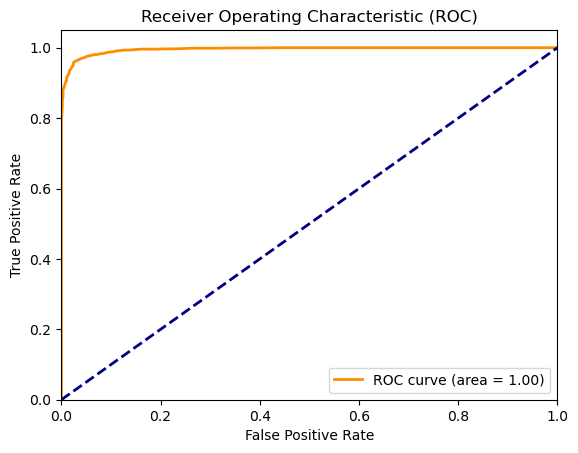

In [16]:
from sklearn.metrics import roc_curve, auc

# Compute ROC curve and ROC area for each class
fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:, 1])
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()